# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 2 - Autoencoders 

In [1]:
# torch modules
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# sklearn and skorch modules
from sklearn.metrics import confusion_matrix

# various modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from tqdm import tqdm
import joblib
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_theme()


# self-made libraries import
from models import StandardAE, DenoisingAE, SupervisedCAE, VariationalAE
from utilities import plot_result, add_noise, MetricsCallback, loss_plot, multiple_plot
from optimization import return_objective

#LIGHTNING
import pytorch_lightning as pl


label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']

In [2]:
import sys, importlib
importlib.reload(sys.modules['models'])
importlib.reload(sys.modules['optimization'])
importlib.reload(sys.modules['utilities'])

<module 'utilities' from 'c:\\Users\\Filippo\\Documents\\POD\\Projects\\NNDL\\HW2\\utilities.py'>

## Dataset and Dataloaders

In [3]:
# creating the transformations list
transformations = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(degrees=15, translate=(.05, .05), scale=(0.95,1.05)) , transforms.ToTensor() ])

# loading train and test dataset
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

train_dataset.transform = transformations
test_dataset.transform = transformations

train_split_dataset, val_dataset = torch.utils.data.random_split(train_dataset,[50000,10000])

In [4]:
n_cores = torch.get_num_threads()
### Define train dataloader
train_dataloader = DataLoader(train_split_dataset, batch_size=128, shuffle=True, num_workers=n_cores)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=n_cores)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=n_cores)


# Standard autoencoder instantiation

In [39]:
trainer = pl.Trainer(max_epochs=10,enable_checkpointing=False, callbacks=[MetricsCallback()])

std_ae = StandardAE({"opt":"Adam","lr":1e-3,"reg":0,"encoded_space_dim":20,"in_channels":[20,50,40],"linear_size":130,"act_func":nn.ReLU})
std_ae.load_state_dict(torch.load("params/autoencoder_weights.pth"))
# trainer.fit(std_ae,train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


<All keys matched successfully>

In [27]:
# torch.save(model.state_dict(), "autoencoder_weights.pth")
# torch.save(model.encoder.state_dict(), "encoder_weights.pth")
# np.save("losses/train_loss_std_ae",trainer.callbacks[0].metrics["train_loss"])
# np.save("losses/val_loss_std_ae",trainer.callbacks[0].metrics["val_loss"])

## Autoencoding Test

c:\Users\Filippo\Documents\POD\Projects\NNDL\HW2\utilities.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  def loss_plot(train_loss,val_loss, ax):


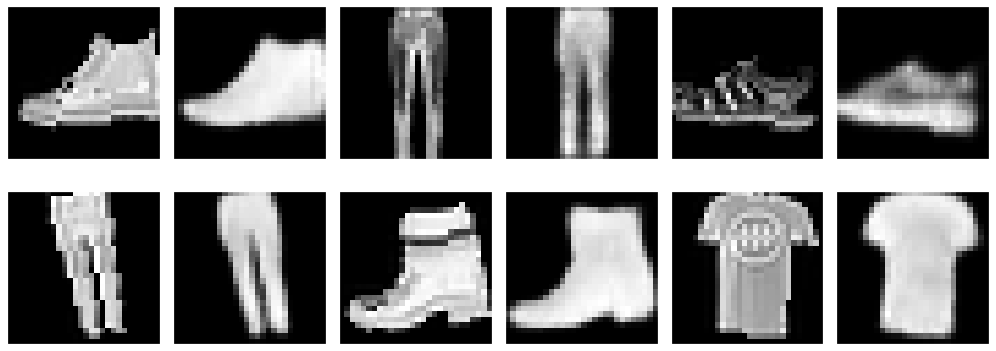

In [66]:
ims = []

for i in range(6):
    im = train_dataset[np.random.randint(1,10000)][0][0]
    ims.append({"img":im})
    ims.append({"img":std_ae.forward(im.reshape([1,1,28,28])).detach()[0][0]})
    
multiple_plot(plot_result,[2,6], [14,7],ims)

plt.savefig("figures/std_ae_test.pdf")

## Network analysis

### Loss plot

In [67]:
train_loss = np.load("losses/train_loss_std_ae.npy")
val_loss = np.load("losses/val_loss_std_ae.npy")

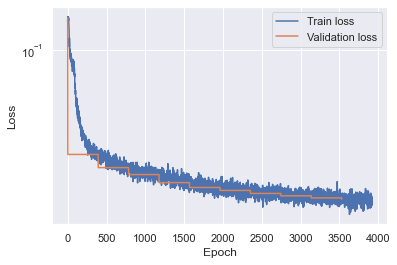

In [69]:
fig, ax = plt.subplots(1,1)
loss_plot(train_loss,val_loss,ax)
plt.savefig("figures/loss_ae.pdf")

### Sample creation

In [71]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to("cpu")
    label = sample[1]
    # Encode image
    std_ae.encoder.eval()
    with torch.no_grad():
        encoded_img  = std_ae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)

100%|██████████| 10000/10000 [00:13<00:00, 750.32it/s]


c:\Users\Filippo\Documents\POD\Projects\NNDL\HW2\utilities.py:24: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



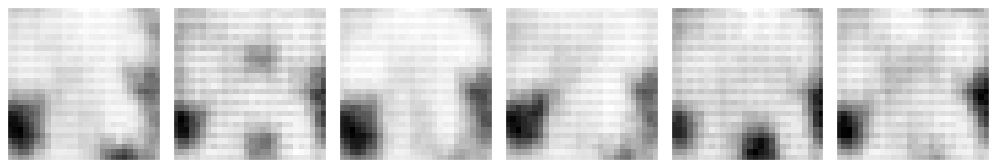

In [86]:
ims = []

for i in range(6):
    sample = torch.tensor(np.random.rand(20)).float().unsqueeze(0)
    ims.append({"img":std_ae.decoder.forward(sample).detach()[0][0]})
    
multiple_plot(plot_result,[1,6], [14,3],ims)

plt.savefig("figures/std_ae_random_samples.pdf")

### TSNE

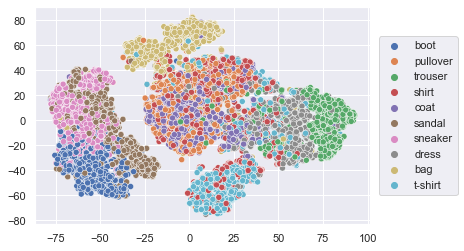

In [94]:
tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)

g = sns.scatterplot( x=encoded_samples_reduced_TSNE[:,0], y=encoded_samples_reduced_TSNE[:,1], hue=[label_names[l] for l in encoded_samples.label.to_numpy()])
g.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1) 

plt.savefig("figures/std_ae_tsne.pdf")

### PCA

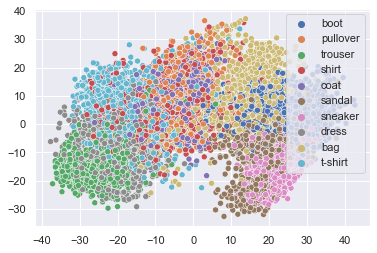

In [99]:
pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)

sns.scatterplot( x=encoded_samples_reduced_PCA[:,0], y=encoded_samples_reduced_PCA[:,1], hue=[label_names[l] for l in encoded_samples.label.to_numpy()])
g.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1) 

plt.savefig("figures/std_ae_pca.pdf")

# Denoising autoencoder

In [ ]:
trainer = pl.Trainer(max_epochs=10)

den_ae = DenoisingAE({"opt":"Adam","lr":4e-3,"reg":3e-5,"encoded_space_dim":30,"in_channels":[50,50,40],"linear_size":70,"act_func":nn.ReLU, "out_linear_size":170})
den_ae.load_state_dict(torch.load("params/denoisingAE_weights.pth"))

#trainer.fit(den_ae,train_dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\Filippo\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name    | Type    | Params
------------------------------------
0 | loss_fn | MSELoss | 0     
1 | encoder | Encoder | 68.5 K
2 | decoder | Decoder | 68.8 K
------------------------------------
137 K     Trainable params
0         Non-trainable params
137 K     Total params
0.549     Total estimated model params size (MB)


Epoch 0:   1%|          | 3/391 [00:08<18:18,  2.83s/it, loss=0.211, v_num=152]

C:\Users\Filippo\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
# torch.save(den_ae.state_dict(), "params/denoisingAE_weights.pth")

## Denoising example

c:\Users\Filippo\Documents\POD\Projects\NNDL\HW2\utilities.py:24: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



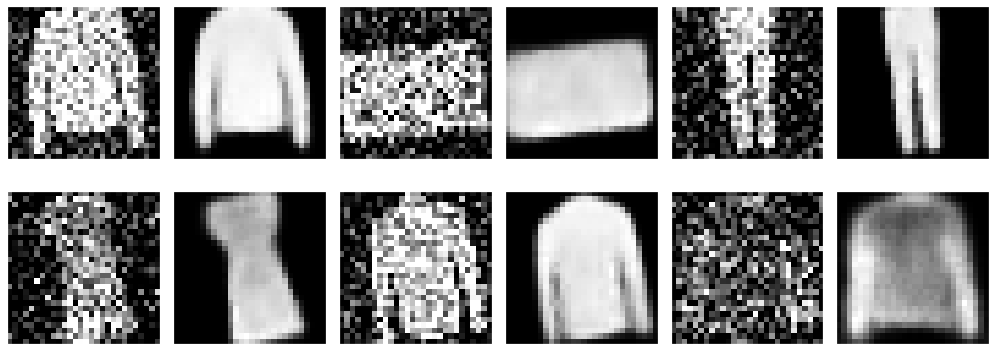

In [96]:
ims = []
for i in range(6):
    im = train_dataset[np.random.randint(1,10000)][0][0]
    ims.append({"img":add_noise(im)})
    ims.append({"img":std_ae.forward(im.reshape([1,1,28,28])).detach()[0][0]})
    
multiple_plot(plot_result,[2,6], [14,7],ims)

plt.savefig("figures/den_ae_test.pdf")

# Supervised learning application

In [60]:
trainer = pl.Trainer(max_epochs=10)

supervised_ae = SupervisedCAE({"opt":"Adam","lr":1e-4,"reg":0,"encoded_space_dim":20,"in_channels":[20,50,40],"linear_size":130,"act_func":nn.ReLU, "out_linear_size":200},PATH="params/encoder_weights.pth")
supervised_ae.load_state_dict(torch.load("params/supervisedCAE_weights.pth"))

# trainer.fit(supervised_ae,train_dataloader, val_dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


<All keys matched successfully>

In [ ]:
# torch.save(supervised_ae.state_dict(), "params/supervisedCAE_weights.pth")

In [61]:
y_pred = []
y_true = []

for inputs, labels in test_dataloader:
        output = supervised_ae.forward(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

C:\Users\Filippo\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


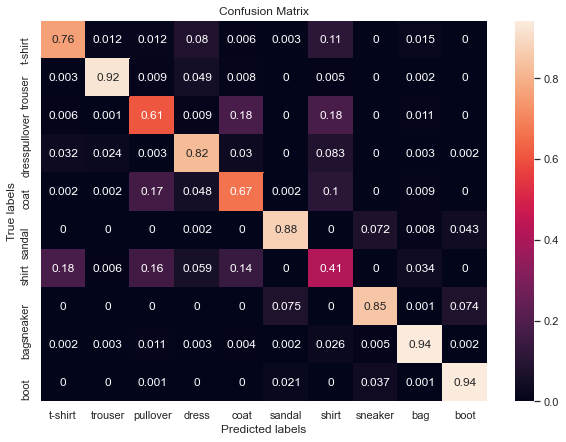

In [97]:
# plotting the confusion matrix for the prediction
fig, ax = plt.subplots(figsize = (10,7))
c_matrix = confusion_matrix(y_true,y_pred)
sns.heatmap(c_matrix/c_matrix.astype(float).sum(axis=1) ,annot=True)

ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_names); ax.yaxis.set_ticklabels(label_names);

plt.savefig("figures/conf_matrix.pdf")

# Variational Autoencoder

In [6]:
trainer = pl.Trainer(max_epochs=10)

var_ae = VariationalAE(hyper={"opt":"Adam","lr":1e-2,"reg":0,"encoded_space_dim":40,"in_channels":[16,32,64],"linear_size":100,"act_func":nn.ReLU, "out_linear_size":100})

var_ae.load_state_dict(torch.load("params/variationalAE_weights.pth"))
# trainer.fit(var_ae,train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


<All keys matched successfully>

Epoch 4:  23%|██▎       | 91/391 [00:38<02:06,  2.38it/s, loss=3.39e+04, v_num=153]

In [ ]:
# torch.save(var_ae.state_dict(), "params/variationalAE_weights.pth")

## Autoencoding test

c:\Users\Filippo\Documents\POD\Projects\NNDL\HW2\utilities.py:24: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



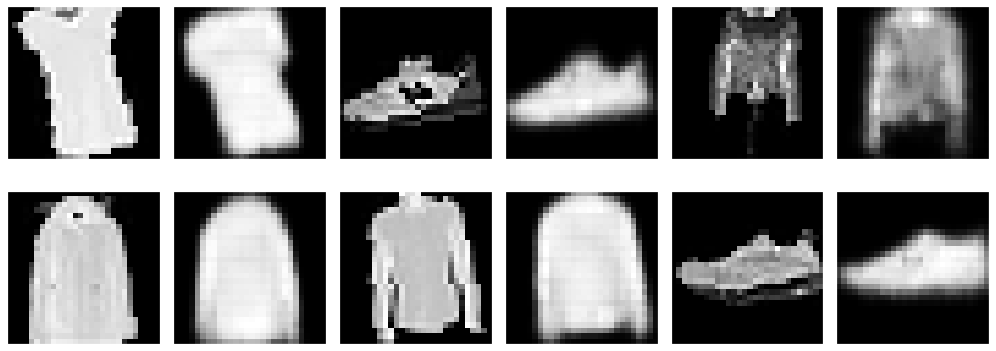

In [100]:
ims = []

for i in range(6):
    im = train_dataset[np.random.randint(1,10000)][0][0]
    ims.append({"img":im})
    ims.append({"img":var_ae.forward(im.reshape([1,1,28,28])).detach()[0][0]})
    
multiple_plot(plot_result,[2,6], [14,7],ims)

plt.savefig("figures/vae_ae_test.pdf")

## TSNE and PCA plot

In [8]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to("cpu")
    label = sample[1]
    # Encode image
    var_ae.encoder.eval()
    with torch.no_grad():
        encoded_img  = var_ae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)

100%|██████████| 10000/10000 [00:12<00:00, 774.61it/s]


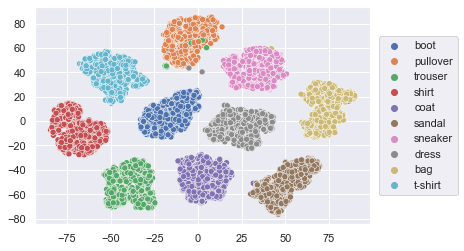

In [104]:
tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
g = sns.scatterplot( x=encoded_samples_reduced_TSNE[:,0], y=encoded_samples_reduced_TSNE[:,1], hue=[label_names[l] for l in encoded_samples.label.to_numpy()])
g.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1) 

plt.savefig("figures/vae_tsne.pdf")

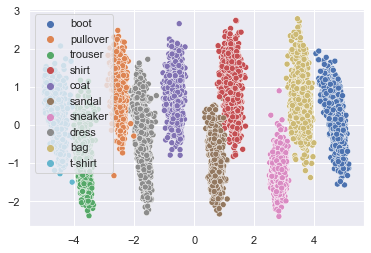

In [11]:
pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)

sns.scatterplot( x=encoded_samples_reduced_PCA[:,0], y=encoded_samples_reduced_PCA[:,1], hue=[label_names[l] for l in encoded_samples.label.to_numpy()])
g.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1) 

# Optuna optimization tests

In [ ]:
# objective = return_objective(StandardAE,train_dataset,10,device="cpu")
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=70)
study = joblib.load("studies/study.pkl")
#joblib.dump(study,"study.pkl")


In [ ]:
# objective_den = return_objective(DenoisingAE,train_dataset,10)

# study_den = optuna.create_study(direction='minimize')
# study_den.optimize(objective_den, n_trials=70)
study = joblib.load("studies/study_den.pkl")
# joblib.dump(study_den,"study_den.pkl")


In [ ]:
# objective_vae = return_objective(VariationalAE,train_dataset,10)

# study_vae = optuna.create_study(direction='minimize')
# study_vae.optimize(objective_vae, n_trials=70)
study = joblib.load("studies/study_vae.pkl")
# joblib.dump(study_vae,"study_vae.pkl")